In [1]:
import imageio
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import numpy as np
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D, AveragePooling2D, GlobalAveragePooling2D, Rescaling

# im = imageio.imread('face_age/001/1000.png')
# print(im.shape)

# plt.imshow(im, interpolation='nearest')
# plt.show()

In [18]:
from sklearn.model_selection import train_test_split

data_dir = "face_age"

batch_size = 32
img_height = 200
img_width = 200


train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.8,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

rest_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.8,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

rest_ds_X = np.concatenate([x for x, y in rest_ds], axis=0)
rest_ds_y = np.concatenate([y for x, y in rest_ds], axis=0)

X_val, X_test, y_val, y_test = train_test_split(rest_ds_X, rest_ds_y, test_size=0.9, random_state=42)
print(rest_ds_X.shape)
print(X_val.shape)

Found 9778 files belonging to 11 classes.
Using 1956 files for training.
Found 9778 files belonging to 11 classes.
Using 7822 files for validation.
(7822, 200, 200, 3)
(782, 200, 200, 3)


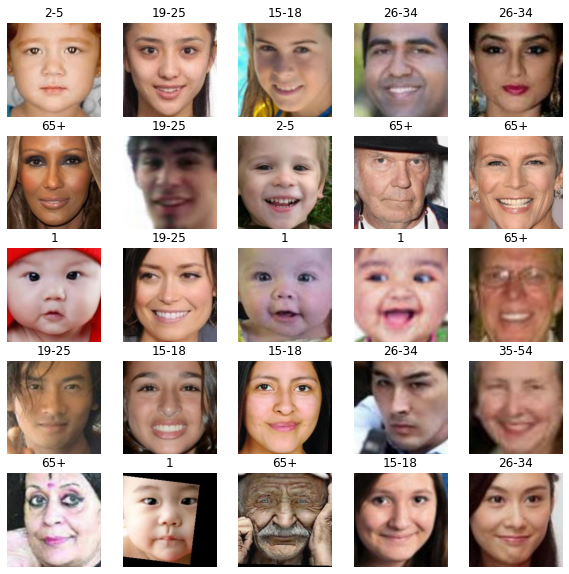

In [19]:
# Shows 25 random images from the training dataset
def display_data():
    class_names = train_ds.class_names
    plt.figure(figsize=(10, 10))
    for images, labels in train_ds.take(1):
        for i in range(25):
            ax = plt.subplot(5, 5, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i]])
            plt.axis("off")
            
display_data()

In [20]:
class_names = train_ds.class_names
AUTOTUNE = tf.data.AUTOTUNE

# keeps images in memory after they are loaded in the first epoch.
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
rest_ds = rest_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [21]:
normalization_layer = layers.Rescaling(1. / 255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))

In [23]:

num_classes = len(class_names)

data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

# Defining the architecture of the sequential neural network.

final_cnn = Sequential()

# Input layer with 32 filters, followed by an AveragePooling2D layer.
final_cnn.add(Rescaling(1./255, input_shape=(img_height, img_width, 3))),
final_cnn.add(Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=(200, 200, 3)))    # 3rd dim = 1 for grayscale images.
final_cnn.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
final_cnn.add(AveragePooling2D(pool_size=(2,2)))
final_cnn.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
final_cnn.add(AveragePooling2D(pool_size=(2,2)))
final_cnn.add(Conv2D(filters=256, kernel_size=3, activation='relu'))
final_cnn.add(AveragePooling2D(pool_size=(2,2)))
final_cnn.add(GlobalAveragePooling2D())
final_cnn.add(Dense(132, activation='relu'))
final_cnn.add(Dense(num_classes, activation='relu'))

model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.5),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.5),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])
model.summary()


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_6 (Sequential)   (None, 200, 200, 3)       0         
                                                                 
 rescaling_7 (Rescaling)     (None, 200, 200, 3)       0         
                                                                 
 conv2d_18 (Conv2D)          (None, 200, 200, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 100, 100, 16)     0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 100, 100, 16)      0         
                                                                 
 conv2d_19 (Conv2D)          (None, 100, 100, 32)      4640      
                                                      

In [24]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
# final_cnn.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer='adam', metrics=['accuracy'])

In [25]:
final_cnn.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_6 (Rescaling)     (None, 200, 200, 3)       0         
                                                                 
 conv2d_14 (Conv2D)          (None, 198, 198, 32)      896       
                                                                 
 conv2d_15 (Conv2D)          (None, 196, 196, 64)      18496     
                                                                 
 average_pooling2d_6 (Averag  (None, 98, 98, 64)       0         
 ePooling2D)                                                     
                                                                 
 conv2d_16 (Conv2D)          (None, 96, 96, 128)       73856     
                                                                 
 average_pooling2d_7 (Averag  (None, 48, 48, 128)      0         
 ePooling2D)                                          

In [ ]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=(X_val, y_val),
  epochs=epochs
)

Epoch 1/10
62/62 [==============================] - 35s 531ms/step - loss: 2.6087 - accuracy: 0.1708 - val_loss: 2.3225 - val_accuracy: 0.1803
Epoch 2/10
41/62 [==================>...........] - ETA: 8s - loss: 2.1692 - accuracy: 0.1815

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

NameError: name 'history' is not defined